In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [3]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

In [4]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

In [5]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


In [6]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
num_classes = len(label_encoder.classes_)

### checking if max-words are good

Max length: 432
Mean length: 154.73435
Median length: 150.0


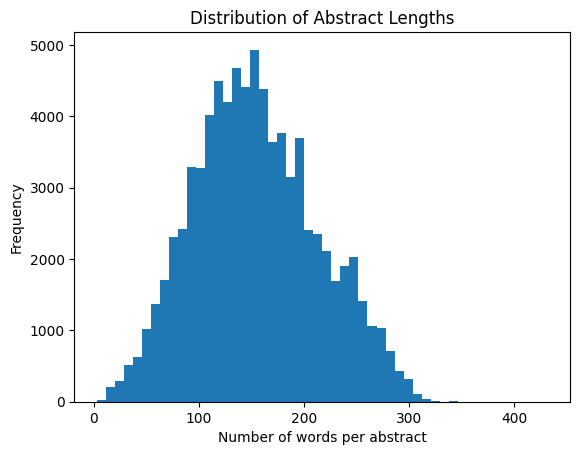

In [7]:
# Number of tokens in each abstract
abstract_lengths = train_df['clean_abstract'].apply(lambda x: len(x.split()))

# Basic stats
print("Max length:", abstract_lengths.max())
print("Mean length:", abstract_lengths.mean())
print("Median length:", abstract_lengths.median())

# Optional: Histogram to visualize
import matplotlib.pyplot as plt

plt.hist(abstract_lengths, bins=50)
plt.xlabel("Number of words per abstract")
plt.ylabel("Frequency")
plt.title("Distribution of Abstract Lengths")
plt.show()


In [8]:
from collections import Counter

# Get all words from the abstracts
all_words = " ".join(train_df['clean_abstract']).split()
word_freq = Counter(all_words)

print("Total unique words:", len(word_freq))

# Look at top N
print(word_freq.most_common(10))


Total unique words: 404114
[('the', 889948), ('of', 508097), ('and', 324780), ('a', 302415), ('in', 268166), ('to', 264902), ('we', 196670), ('is', 159279), ('for', 148360), ('that', 123876)]


In [9]:
# Tokenize the text
max_words = 10000  # Consider top 10,000 words
max_sequence_length = 150  # Truncate or pad abstracts to this length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_abstract'])

# Convert text to sequences of indices
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_abstract'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_abstract'])

In [10]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [11]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Bidirectional, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
model = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    GlobalAveragePooling1D(),  # MUCH faster than RNNs
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_simple_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [14]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3725 - loss: 1.8124 - val_accuracy: 0.7327 - val_loss: 0.8709
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7037 - loss: 0.9357 - val_accuracy: 0.7686 - val_loss: 0.7515
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7483 - loss: 0.8079 - val_accuracy: 0.7828 - val_loss: 0.7024
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7731 - loss: 0.7351 - val_accuracy: 0.7878 - val_loss: 0.6777
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7903 - loss: 0.6869 - val_accuracy: 0.7962 - val_loss: 0.6566
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8029 - loss: 0.6532 - val_accuracy: 0.7984 - val_loss: 0.6424
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8136 - loss: 0.6228 - val_accuracy: 0.8029 - val_loss: 0.6304
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8252 - loss: 0

In [16]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8045 - loss: 0.6034
Test accuracy: 0.8073


In [17]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

# Calculate metrics
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Macro F1: {metrics.f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.93      0.91      0.92      2013
    cond-mat       0.78      0.80      0.79      2058
          cs       0.71      0.67      0.69      1995
        eess       0.74      0.80      0.76      1948
      hep-ph       0.90      0.90      0.90      1990
      hep-th       0.89      0.87      0.88      2019
        math       0.83      0.86      0.84      2042
     physics       0.68      0.58      0.63      1977
    quant-ph       0.83      0.86      0.84      2013
        stat       0.78      0.83      0.80      1945

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Macro F1: 0.8054
Weighted F1: 0.8059


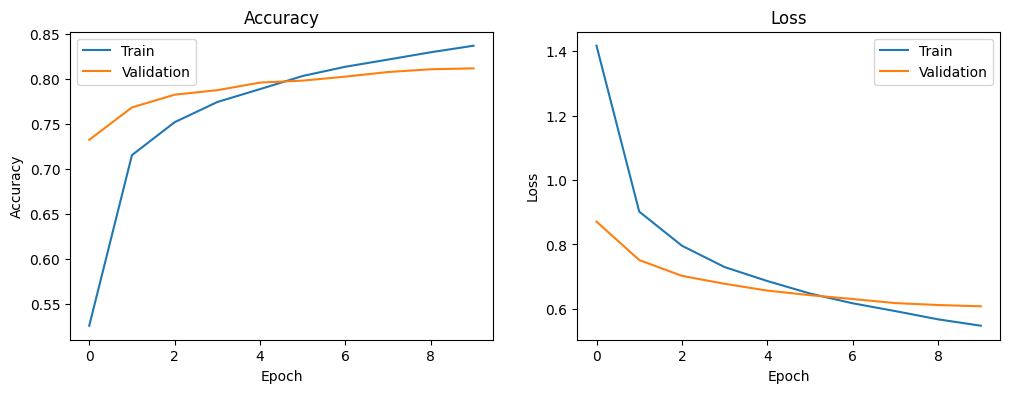

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# LSTM 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf

# LSTM-based model
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    LSTM(64, return_sequences=False),  # You can try return_sequences=True + more layers
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [20]:
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
callbacks_lstm = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_lstm_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [22]:
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks_lstm
)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 68ms/step - accuracy: 0.2720 - loss: 1.8466 - val_accuracy: 0.5807 - val_loss: 1.0930
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 151s 76ms/step - accuracy: 0.5850 - loss: 1.1127 - val_accuracy: 0.4647 - val_loss: 1.3391
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 134s 67ms/step - accuracy: 0.4789 - loss: 1.3671 - val_accuracy: 0.6141 - val_loss: 1.0445
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 136s 68ms/step - accuracy: 0.6024 - loss: 1.0957 - val_accuracy: 0.6369 - val_loss: 1.0278
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.6799 - loss: 0.9346 - val_accuracy: 0.7055 - val_loss: 0.8209
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 134s 67ms/step - accuracy: 0.7331 - loss: 0.7722 - val_accuracy: 0.7352 - val_loss: 0.7746
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 134s 67ms/step - accuracy: 0.7705 - loss: 0.6833 - val_accuracy: 0.7522 - val_loss: 0.7620
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 135s 67ms/step - accuracy: 

In [23]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Test accuracy: {test_acc_lstm:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7994 - loss: 0.6681
LSTM Test accuracy: 0.7978


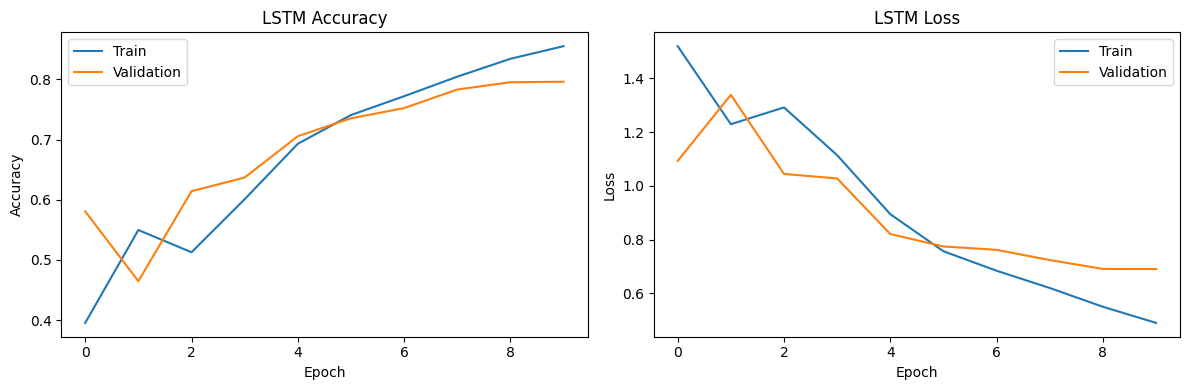

In [24]:
import matplotlib.pyplot as plt

# Plot training history for LSTM model
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Validation')
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# GRU

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf

# GRU-based model
model_gru = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_gru = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_gru_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Training GRU model
history_gru = model_gru.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks_gru
)

# Evaluation
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test_pad, y_test)
print(f"GRU Test accuracy: {test_acc_gru:.4f}")


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 143s 70ms/step - accuracy: 0.3040 - loss: 1.7828 - val_accuracy: 0.7009 - val_loss: 0.8208
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 147s 73ms/step - accuracy: 0.7159 - loss: 0.8282 - val_accuracy: 0.7619 - val_loss: 0.6949
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.7848 - loss: 0.6633 - val_accuracy: 0.7815 - val_loss: 0.6527
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 153s 76ms/step - accuracy: 0.8216 - loss: 0.5702 - val_accuracy: 0.7823 - val_loss: 0.6552
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - accuracy: 0.8450 - loss: 0.5053 - val_accuracy: 0.7879 - val_loss: 0.6597
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7879 - loss: 0.6370
GRU Test accuracy: 0.7865


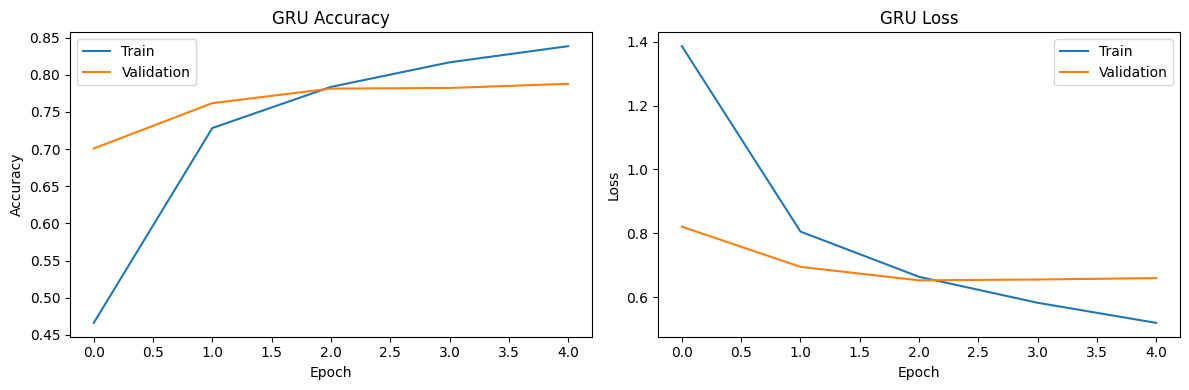

In [26]:
import matplotlib.pyplot as plt

# Plot training history for GRU model
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Validation')
plt.title('GRU Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Validation')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# bi RNN

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras import regularizers
import tensorflow as tf

# Bidirectional RNN-based model
model_bidir_rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    Bidirectional(GRU(64)),  # Bidirectional GRU RNN layer
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_bidir_rnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_bidir_rnn = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_bidir_rnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Training the Bidirectional RNN model
history_bidir_rnn = model_bidir_rnn.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks_bidir_rnn
)

# Evaluate test accuracy for Bidirectional RNN
test_loss_bidir_rnn, test_acc_bidir_rnn = model_bidir_rnn.evaluate(X_test_pad, y_test)
print(f"Bidirectional RNN Test accuracy: {test_acc_bidir_rnn:.4f}")


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 171s 82ms/step - accuracy: 0.3491 - loss: 1.7331 - val_accuracy: 0.7295 - val_loss: 0.8003
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 152s 76ms/step - accuracy: 0.7467 - loss: 0.7747 - val_accuracy: 0.7750 - val_loss: 0.6734
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 181s 91ms/step - accuracy: 0.8072 - loss: 0.6160 - val_accuracy: 0.7814 - val_loss: 0.6706
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 159s 80ms/step - accuracy: 0.8387 - loss: 0.5282 - val_accuracy: 0.7926 - val_loss: 0.6549
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8608 - loss: 0.4608 - val_accuracy: 0.7895 - val_loss: 0.6733
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 166s 83ms/step - accuracy: 0.8825 - loss: 0.4033 - val_accuracy: 0.7837 - val_loss: 0.7323
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7953 - loss: 0.6463
Bidirectional RNN Test accuracy: 0.7936


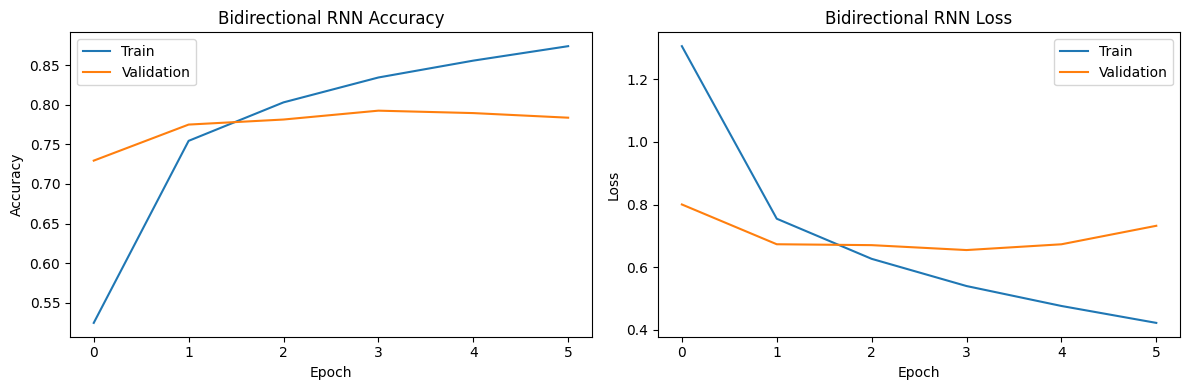

In [31]:
import matplotlib.pyplot as plt

# Plot training history for Bidirectional RNN model
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_bidir_rnn.history['accuracy'], label='Train')
plt.plot(history_bidir_rnn.history['val_accuracy'], label='Validation')
plt.title('Bidirectional RNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_bidir_rnn.history['loss'], label='Train')
plt.plot(history_bidir_rnn.history['val_loss'], label='Validation')
plt.title('Bidirectional RNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


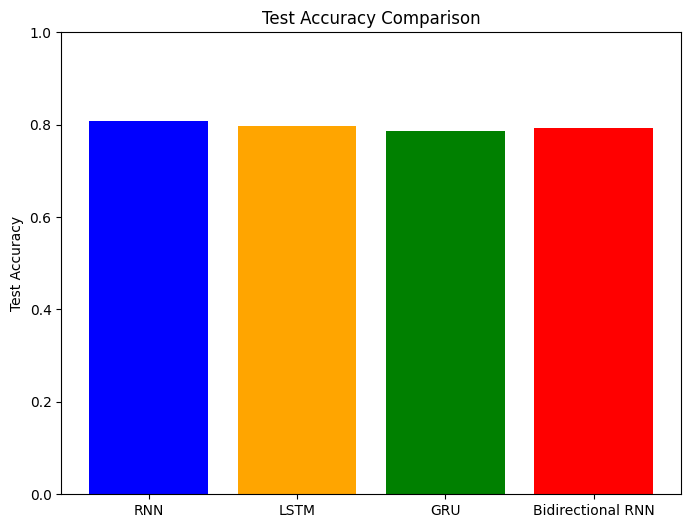

In [30]:
# Test accuracies for each model, including Bidirectional RNN
test_accuracies = [test_acc, test_acc_lstm, test_acc_gru, test_acc_bidir_rnn]
model_names = ['RNN', 'LSTM', 'GRU', 'Bidirectional RNN']

# Plotting test accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # To keep the accuracy scale between 0 and 1
plt.show()


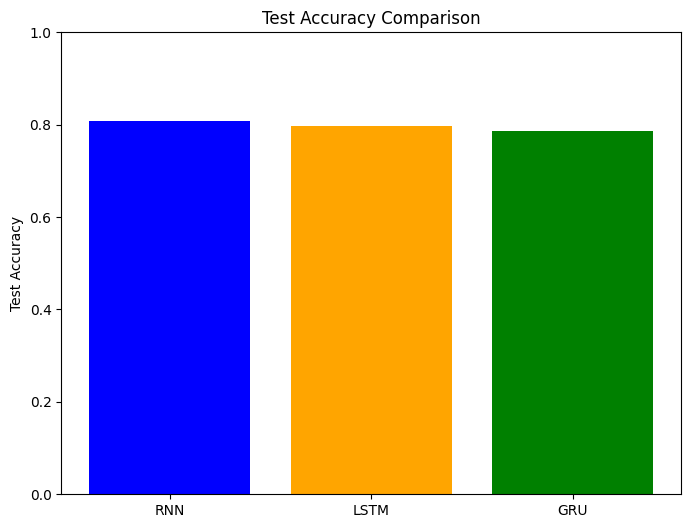

In [28]:
import matplotlib.pyplot as plt

# Test accuracies for each model
test_accuracies = [test_acc, test_acc_lstm, test_acc_gru]
model_names = ['RNN', 'LSTM', 'GRU']

# Plotting test accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # To keep the accuracy scale between 0 and 1
plt.show()
